# CAMALAB ML 暑期班作业
## 第六周：搭建一个数字识别项目

在此文件中，我们提供给你了一个模板，以便于你根据项目的要求一步步实现要求的功能，进而完成整个项目。如果你认为需要导入另外的一些代码，请确保你正确导入了他们，并且包含在你的提交文件中。以**'练习'**开始的标题表示接下来你将开始实现你的项目。注意有一些练习是可选的，并且用**'可选'**标记出来了。

在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以'练习'开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**注意：** Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 连接 mnist 的字符来合成数据

你可以通过连接[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了快速导入数据集，我们可以使用 [Keras Datasets](https://keras.io/datasets/#mnist-database-of-handwritten-digits) [中文文档](http://keras-cn.readthedocs.io/en/latest/other/datasets/#mnist)。

### 载入 mnist
载入mnist时，你可能遇到下述错误： *URL fetch failure on https://s3.amazonaws.com/img-datasets/mnist.npz: None -- [Errno 60] Operation timed out*

解决方案：我们已经为你下载好了`mnist.npz`文件，就在作业的目录下。你只要把该文件放到`~/.keras/datasets`目录下，就能够正常读数据。如果是windows用户，可能需要运行下面的代码块，然后自己查看源代码。

In [2]:
mnist.load_data??

Object `mnist.load_data` not found.


In [1]:
from keras.datasets import mnist

(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]

Using TensorFlow backend.


### 可视化 mnist

我们可以通过 matplotlib 来可视化我们的原始数据集。

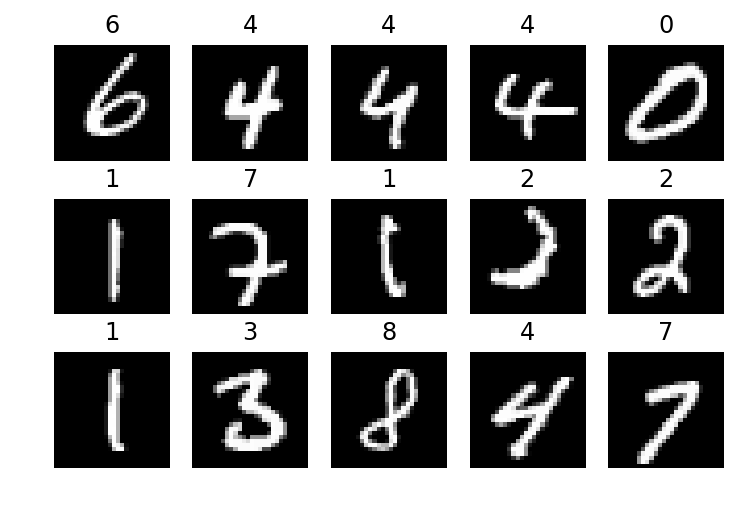

In [2]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, n_train-1)
    plt.title(str(y_raw[index]))
    plt.imshow(X_raw[index], cmap='gray')
    plt.axis('off')

### 练习：合成数据

你需要随机取随机张图片，然后将它们拼接成新的图片。

你需要设置20%的数据作为验证集，以保证模型没有过拟合。

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

n_class, n_len, width, height = 11, 5, 28, 28

def generate_dataset(X, y):
    X_len = X.shape[0]
    
    X_gen = np.zeros((X_len, height, width*n_len, 1), dtype=np.uint8)
    y_gen = [np.zeros((X_len, n_class), dtype=np.uint8) for i in range(n_len)]
    # TODO: 随机取1~5个数字，并拼接成新的图片
    mask =  np.zeros((height, width, 1))
    for i in range(X_len):
        num = random.randint(1, n_len)
        for j in range(n_len):
            if j < num:
                ind = random.randint(0, X_len-1)
                temp = X[ind].reshape((height, height, 1))
                X_gen[i, :, width*j:width*(j+1), :] = temp
                y_gen[j][i][y[ind]] = 1
            else:
                X_gen[i, :, width*j:width*(j+1), :] = mask
                y_gen[j][i][n_class-1] = 1
    
    return X_gen, y_gen

X_raw_train, X_raw_valid, y_raw_train, y_raw_valid = train_test_split(X_raw, y_raw, train_size=0.8, random_state=41)

X_train, y_train = generate_dataset(X_raw_train, y_raw_train)
X_valid, y_valid = generate_dataset(X_raw_valid, y_raw_valid)
X_test, y_test = generate_dataset(X_raw_test, y_raw_test)

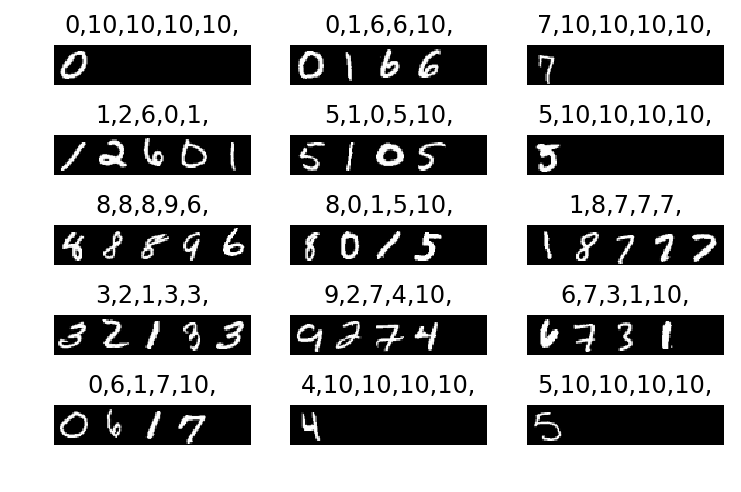

In [4]:
# 显示生成的图片
for i in range(15):
    plt.subplot(5, 3, i+1)
    index = random.randint(0, n_test-1)
    title = ''
    for j in range(n_len):
        title += str(np.argmax(y_test[j][index])) + ','
    
    plt.title(title)
    plt.imshow(X_test[index][:,:,0], cmap='gray')
    plt.axis('off')

### 练习：设计并测试一个模型架构

设计并实现一个能够识别数字序列的深度学习模型。为了产生用于测试的合成数字序列，你可以进行如下的设置：比如，你可以限制一个数据序列最多五个数字，并在你的深度网络上使用五个分类器。同时，你有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

在思考这个问题的时候有很多方面可以考虑：

- 你的模型可以基于深度神经网络或者是卷积神经网络。
- 你可以尝试加入Batch Normalization、Dropout等方法。

在使用 Keras 搭建模型的时候，你可以使用 [函数式模型 API](http://keras-cn.readthedocs.io/en/latest/models/model/) 的方式来搭建多输出模型。

In [5]:
from keras.models import Model
from keras.layers import *

# TODO: 构建你的模型
inputs = Input(shape=(28, 140, 1))
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

outputs = [Dense(n_class, activation='softmax')(x) for i in range(n_len)]
model = Model(inputs=inputs, outputs=outputs)

### 问题 2
_你为解决这个问题采取了什么技术？请详细介绍你使用的技术。_

**回答：** 

- 卷积： 卷积层使用3*3的卷积核进行特征提取，随着层数的加深，卷积层识别的特征也越来越抽象。
- relu激活函数： Relu对于随机梯度下降的收敛有巨大的加速作用，反向传播运算相对sigmoid简单。
- 池化： 采用最大池化进行降采样，在减少了计算量的同时，对原始特征的表达也相对完整。
- Dropout： Dropout以概率p舍弃神经元并让其它神经元以概率q=1-p保留。每个神经元被关闭的概率是相同的。其在训练阶段阻止神经元的共适应，从而防止过拟合。

### 可视化你的网络模型

参考链接：[可视化visualization](http://keras-cn.readthedocs.io/en/latest/other/visualization/)

可以是保存成 PNG 格式显示，也可以直接使用 SVG 格式。 SVG 是矢量图，它的优点是可以无限放大。

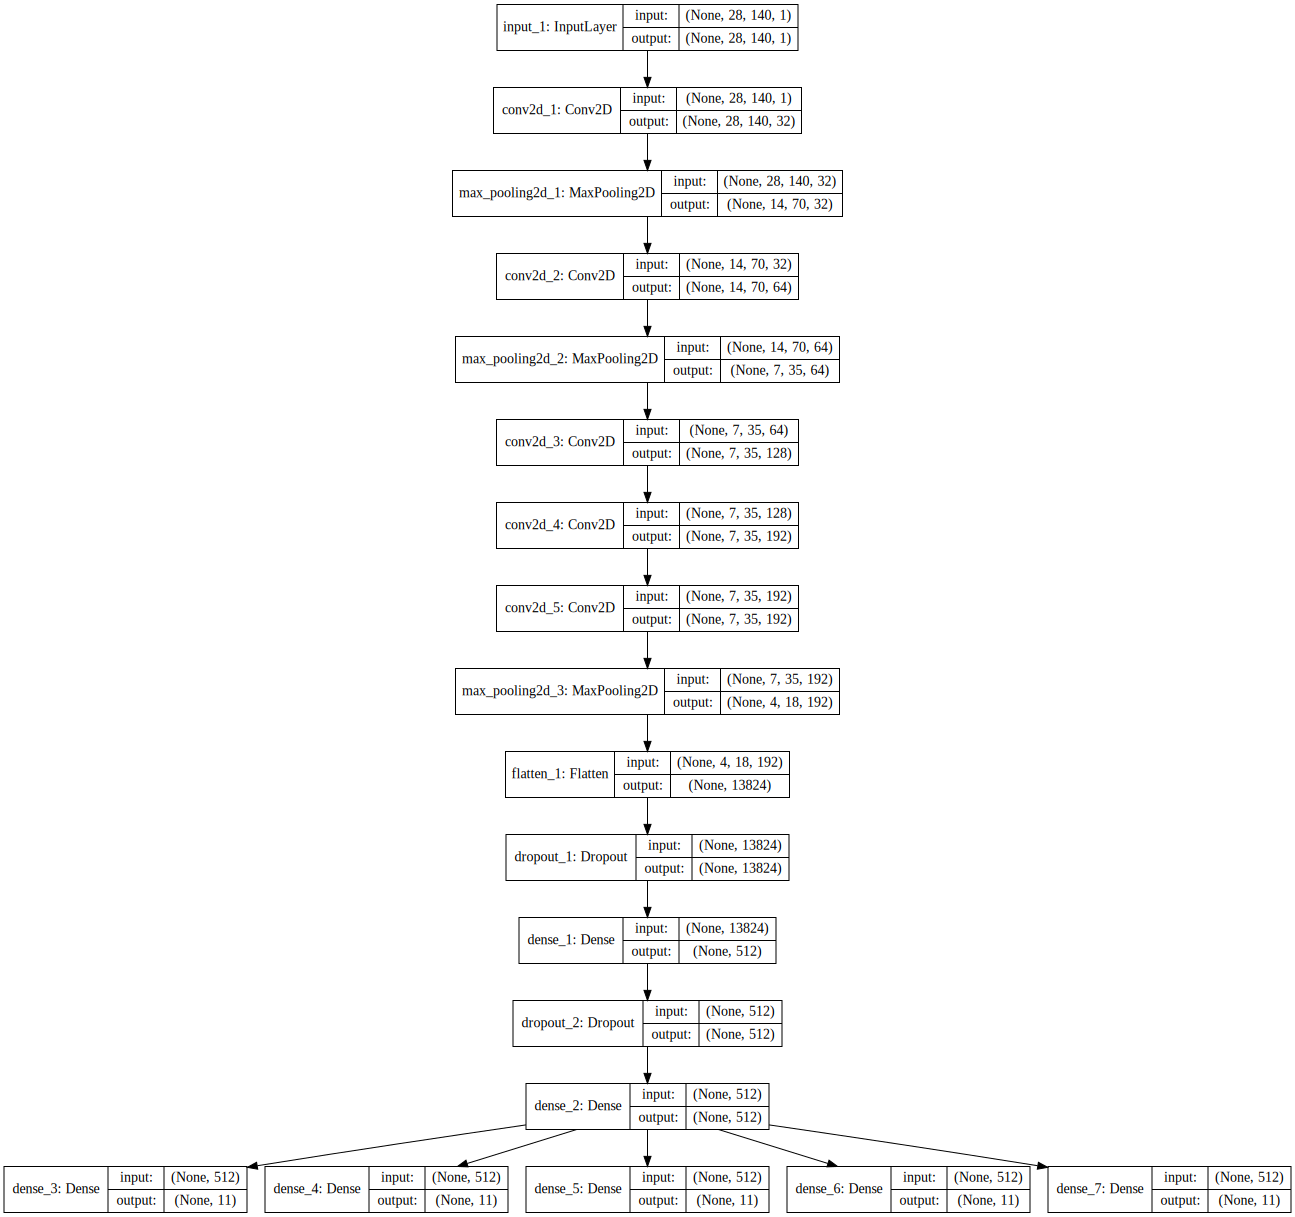

In [6]:
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG

# TODO: 可视化你的模型
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 问题 3
_你最终的模型架构是什么样的？（什么类型的模型，层数，大小, 如何连接等）_

**回答：**

- 使用函数式模型构建了8层卷积神经网络。  
**模型为：**
- 卷积（输入[batch_size, 28, 140, 1]，输出[batch_size, 28, 140, 32]）---> 最大池化(输入[batch_size, 28, 140, 32]，输出[batch_size, 14, 70, 32])
- 卷积（输入[batch_size, 14, 70, 32]，输出[batch_size, 14, 70, 64]）---> 最大池化(输入[batch_size, 14, 70, 64]，输出[batch_size, 7, 35, 64])
- 卷积（输入[batch_size, 7, 35, 64]，输出[batch_size, 7, 35, 128]）
- 卷积（输入[batch_size, 7, 35, 128]，输出[batch_size, 7, 35, 192]）
- 卷积（输入[batch_size, 7, 35, 192]，输出[batch_size, 7, 35, 192]）---> 最大池化(输入[batch_size, 7, 35, 192]，输出[batch_size, 4, 18, 192])
- flatten(输入[batch_size, 4, 18, 192]，输出[batch_size, 13824])(Dropout) ---> 全连接(输入[batch_size, 13824], 输出[batch_size, 512])(Dropout)
- 全连接(输入[batch_size, 512], 输出[batch_size, 512])
- 全连接层（5个），预测结果

### 练习：训练你的网络模型

训练你的模型时，需要设置训练集和验证集。

In [8]:
# TODO: 训练你的模型
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, validation_data=(X_valid, y_valid))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 1129s - loss: 2.0017 - dense_3_loss: 0.5432 - dense_4_loss: 0.4960 - dense_5_loss: 0.4099 - dense_6_loss: 0.3358 - dense_7_loss: 0.2169 - dense_3_acc: 0.8195 - dense_4_acc: 0.8370 - dense_5_acc: 0.8663 - dense_6_acc: 0.8957 - dense_7_acc: 0.9347 - val_loss: 0.2046 - val_dense_3_loss: 0.0626 - val_dense_4_loss: 0.0569 - val_dense_5_loss: 0.0433 - val_dense_6_loss: 0.0242 - val_dense_7_loss: 0.0176 - val_dense_3_acc: 0.9805 - val_dense_4_acc: 0.9838 - val_dense_5_acc: 0.9870 - val_dense_6_acc: 0.9928 - val_dense_7_acc: 0.9948
Epoch 2/10
48000/48000 [==============================] - 1096s - loss: 0.4622 - dense_3_loss: 0.1185 - dense_4_loss: 0.1144 - dense_5_loss: 0.0952 - dense_6_loss: 0.0795 - dense_7_loss: 0.0545 - dense_3_acc: 0.9642 - dense_4_acc: 0.9667 - dense_5_acc: 0.9709 - dense_6_acc: 0.9759 - dense_7_acc: 0.9832 - val_loss: 0.1661 - val_dense_3_loss: 0.0435 - val_dense_

### 练习：计算你的模型准确率

我们刚才得到了模型每个数字的准确率，现在让我们来计算整体准确率，按照完全预测正确数字序列的标准来计算。

比如 1,2,3,10,10 预测成了 1,2,10,10,10 算错，而不是算对了80%。

In [9]:
def evaluate(model):
    # TODO: 按照错一个就算错的规则计算准确率
    y_pred = model.predict(X_test)
    num = 0
    for ind in range(X_test.shape[0]):
        equal = True
        for i in range(n_len):
            if np.argmax(y_test[i][ind]) != np.argmax(y_pred[i][ind]):
                equal = False
        if equal == True:
            num += 1
    print(float(num) / X_test.shape[0])

evaluate(model)

0.9695


### 问题 4

_你的模型准确率有多少？你觉得你的模型足以解决问题吗？_

**回答：**

- 准确率：0.9695
- 对于简单的数字识别这个准确率应该是足够的，但是对于要求很精密的方面，比如银行卡号等可能有点低。

### 预测值可视化

我们将模型的预测结果和真实值画出来，观察真实效果。

(-0.5, 139.5, 27.5, -0.5)

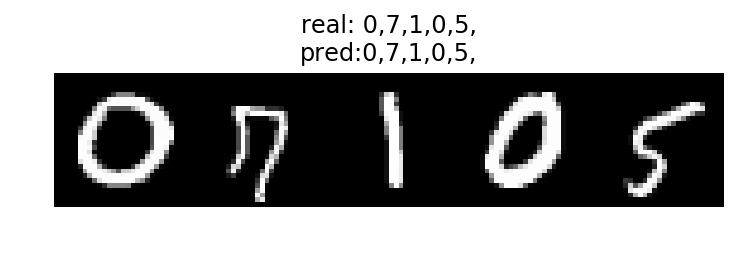

In [10]:
def get_result(result):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        resultstr += str(np.argmax(result[i])) + ','
    return resultstr

index = random.randint(0, n_test-1)
y_pred = model.predict(X_test[index].reshape(1, height, width*n_len, 1))

plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), get_result(y_pred)))
plt.imshow(X_test[index,:,:,0], cmap='gray')
plt.axis('off')

### 保存模型

模型达到满意的效果以后，我们需要保存模型，以便下次调用。

读取的方式也很简单：`model = load_model('model.h5')`

In [11]:
model.save('model.h5')